## Segmentation of Nuclei Using Convolutional Neural Network (CNN)

## Load data
https://www.kaggle.com/takuok/keras-generator-starter-lb-0-326

Convolutional Neural Networks (CNNs) are multi-layered neural networks that are especially efficient at image classification. They can reduce the number of parameters to be tuned making it able to handle the high dimensionality of raw images. 

In [316]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

In [299]:
### resize train images and masks
train_path = 'data/stage1_train/'
train_ids = os.listdir(train_path)[1:]

img_size = 128
IMG_CHANNELS = 3

X_train = np.zeros((len(train_ids), img_size, img_size, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), img_size, img_size, 1), dtype=np.bool)
for i, id_ in tqdm(enumerate(train_ids)):
        path = train_path + id_
        img = cv2.imread(path + '/images/' + id_ + '.png')
        img = cv2.resize(img, (img_size, img_size))
        X_train[i] = img
        mask = np.zeros((img_size, img_size, 1), dtype=np.bool)
        for mask_file in os.listdir(path + '/masks/'):
            mask_ = cv2.imread(path + '/masks/' + mask_file, 0)
            mask_ = cv2.resize(mask_, (img_size, img_size))
            mask_ = mask_[:, :, np.newaxis]
            mask = np.maximum(mask, mask_)
        Y_train[i] = mask

670it [02:18,  4.84it/s]


In [300]:
### split training and validation data 80/20
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('\nx_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)


x_train (536, 128, 128, 3)
x_test (134, 128, 128, 3)
y_train (536, 128, 128, 1)
y_test (134, 128, 128, 1)


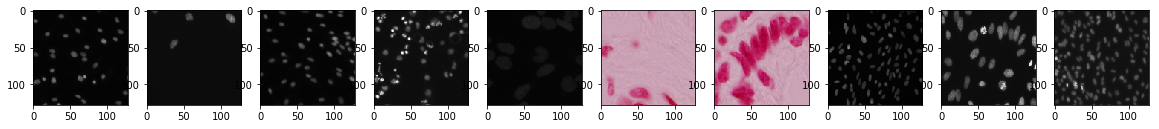

In [392]:
fig, axs = plt.subplots(1, 10, figsize=(20,20))
for i in range(10):
    axs[i].imshow(x_train[i])

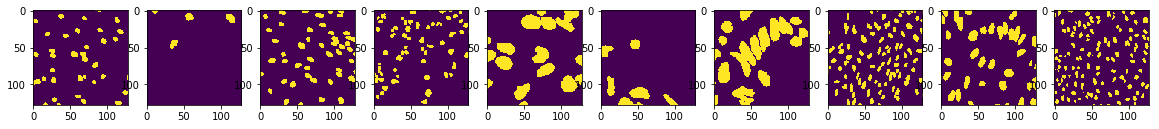

In [302]:
fig, axs = plt.subplots(1, 10, figsize=(20,20))
for i in range(10):
    axs[i].imshow(np.squeeze(y_train[i]))

### Define IoU metric

In [303]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

## Build CNN Model

In [304]:
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS),name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# use dilations to get a slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
# the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_238 (Conv2D)          (None, None, None, 8)     224       
_________________________________________________________________
conv2d_239 (Conv2D)          (None, None, None, 8)     584       
_________________________________________________________________
conv2d_240 (Conv2D)          (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_241 (Conv2D)          (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_242 (Conv2D)          (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_243 (Conv2D)          (None, None, None, 16)    528       
__________

In [305]:
#compile the model
simple_cnn.compile(optimizer = 'adam', loss = dice_coef_loss, metrics = [dice_coef])

In [306]:
history = simple_cnn.fit(X_train,Y_train, validation_data=(x_test,y_test), epochs = 5)

Train on 670 samples, validate on 134 samples
Epoch 1/10
670/670 [==============================] - 55s 82ms/step - loss: -0.3563 - dice_coef: 0.3563 - val_loss: -0.3462 - val_dice_coef: 0.3462
Epoch 2/10
670/670 [==============================] - 51s 76ms/step - loss: -0.4649 - dice_coef: 0.4649 - val_loss: -0.4306 - val_dice_coef: 0.4306
Epoch 3/10
670/670 [==============================] - 53s 79ms/step - loss: -0.5046 - dice_coef: 0.5046 - val_loss: -0.4822 - val_dice_coef: 0.4822
Epoch 4/10
670/670 [==============================] - 54s 80ms/step - loss: -0.5218 - dice_coef: 0.5218 - val_loss: -0.5206 - val_dice_coef: 0.5206
Epoch 5/10
670/670 [==============================] - 48s 71ms/step - loss: -0.5231 - dice_coef: 0.5231 - val_loss: -0.5728 - val_dice_coef: 0.5728
Epoch 6/10
670/670 [==============================] - 51s 75ms/step - loss: -0.5388 - dice_coef: 0.5388 - val_loss: -0.5812 - val_dice_coef: 0.5812
Epoch 7/10
670/670 [==============================] - 48s 72ms/ste

In [307]:
print(history.history.keys())

dict_keys(['val_loss', 'val_dice_coef', 'loss', 'dice_coef'])


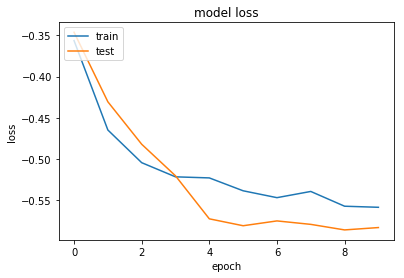

In [308]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict

In [309]:
# Predict on train
preds_train = simple_cnn.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)

603/603 [==============================] - 17s 29ms/step


In [310]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

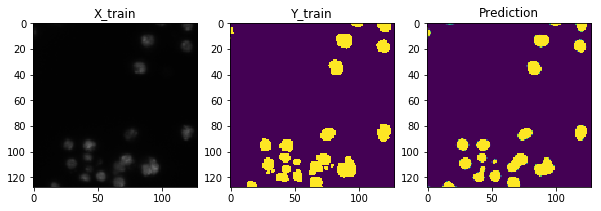

In [311]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))
axs[0].imshow(X_train[0])
axs[1].imshow(np.squeeze(Y_train[0]))
axs[2].imshow(np.squeeze(preds_train[0]))
axs[0].title.set_text('X_train')
axs[1].title.set_text('Y_train')
axs[2].title.set_text('Prediction')

## Evaluate

In [312]:
### create function for overall IoU evaluation
def iou_calc(mask_true, mask_pred):
    '''
    mask_true: the true mask
    mask_pred: the predicted mask
    '''
    mask_true = (np.squeeze(mask_true)*255).astype(np.int64)
    mask_pred = (np.squeeze(mask_pred)*255).astype(np.int64)
    intersection = mask_true & mask_pred
    union = mask_true | mask_pred
    difference = (mask_true | mask_pred) - (mask_true & mask_pred)
    return intersection.sum() / union.sum()

In [313]:
all_iou = []
for i in range(len(preds_train)):
    iou = iou_calc(Y_train[i],preds_train[i])
    all_iou.append(iou)
np.mean(all_iou)

0.57800427227685081

In [314]:
smooth = 1.
def dice_coef2(y_true, y_pred):
    intersection = y_true * y_pred
    return (2. * intersection.sum() + smooth) / (y_true.sum() + y_pred.sum() + smooth)

In [315]:
all_dice = []
for i in range(len(preds_train)):
    dice = dice_coef2(Y_train[i],preds_train[i])
    all_dice.append(dice)
np.mean(all_dice)

0.69910258775218592

The mean IoU for predictions on the training data is 57%. This is not much of an improvement compared to a basic OTSU threshold. 

## Model 2

In [380]:
inputs = Input((img_size, img_size, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.3) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)

u3 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c2)
u3 = concatenate([u3, c1], axis=3)
c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u3)
c3 = Dropout(0.1) (c3)
c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c3)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer = 'adam', loss = dice_coef_loss, metrics = [dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, 128, 128, 3)  0           input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_323 (Conv2D)             (None, 128, 128, 16) 448         lambda_22[0][0]                  
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 128, 128, 16) 0           conv2d_323[0][0]                 
__________________________________________________________________________________________________
conv2d_324

In [362]:




model = Sequential()
model.add(BatchNormalization(input_shape = (img_size, img_size, IMG_CHANNELS),name = 'NormalizeInput')) 

model.add(Conv2D(8, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding = 'same'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), activation='relu', padding = 'same'))
#model.add(Conv2D(16, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))

model.add(Conv2DTranspose(16, (3, 3), padding='same'))
model.add(concatenate(inputs, axis=-1))
model.add(Conv2D(16, (3, 3), activation='relu', padding = 'same'))

model.add(Conv2DTranspose(8, (3, 3), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding = 'same'))

model.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = dice_coef_loss, metrics = [dice_coef])

ValueError: `Concatenate` layer should be called on a list of inputs

In [381]:
history2 = model.fit(X_train,Y_train, validation_data=(x_test,y_test), batch_size=32, epochs = 10)

Train on 670 samples, validate on 134 samples
Epoch 1/10
670/670 [==============================] - 66s 98ms/step - loss: -0.3241 - dice_coef: 0.3241 - val_loss: -0.4543 - val_dice_coef: 0.4543
Epoch 2/10
670/670 [==============================] - 62s 92ms/step - loss: -0.5262 - dice_coef: 0.5262 - val_loss: -0.5615 - val_dice_coef: 0.5615
Epoch 3/10
670/670 [==============================] - 62s 93ms/step - loss: -0.5804 - dice_coef: 0.5804 - val_loss: -0.5965 - val_dice_coef: 0.5965
Epoch 4/10
670/670 [==============================] - 63s 94ms/step - loss: -0.5899 - dice_coef: 0.5899 - val_loss: -0.6055 - val_dice_coef: 0.6055
Epoch 5/10
670/670 [==============================] - 64s 95ms/step - loss: -0.6006 - dice_coef: 0.6006 - val_loss: -0.6103 - val_dice_coef: 0.6103
Epoch 6/10
670/670 [==============================] - 64s 96ms/step - loss: -0.5989 - dice_coef: 0.5989 - val_loss: -0.6153 - val_dice_coef: 0.6153
Epoch 7/10
670/670 [==============================] - 64s 95ms/ste

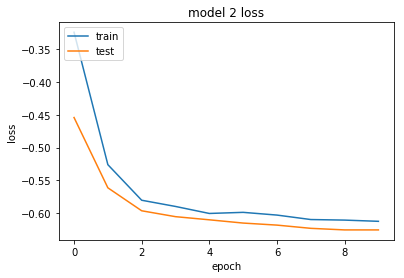

In [382]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [383]:
# Predict on train
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

603/603 [==============================] - 20s 32ms/step


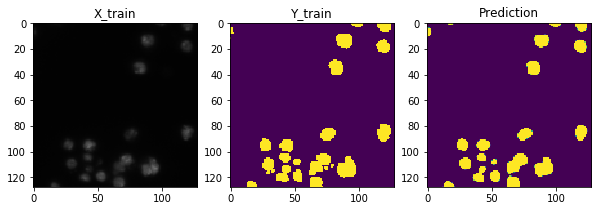

In [384]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))
axs[0].imshow(X_train[0])
axs[1].imshow(np.squeeze(Y_train[0]))
axs[2].imshow(np.squeeze(preds_train[0]))
axs[0].title.set_text('X_train')
axs[1].title.set_text('Y_train')
axs[2].title.set_text('Prediction')

In [385]:
all_dice = []
for i in range(len(preds_train)):
    dice = dice_coef2(Y_train[i],preds_train[i])
    all_dice.append(dice)
np.mean(all_dice)

0.74833436738342407